<a href="https://colab.research.google.com/github/MiniSoda17/comp3710-deep-learning/blob/main/COMP3710_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.3 DawnBench


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# CIFAR-10 transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

# Datasets + Dataloaders
batch_size = 512
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
n_classes = len(classes)

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = None
        if stride != 1 or in_planes != planes:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, planes, blocks, stride):
        layers = []
        layers.append(BasicBlock(self.in_planes, planes, stride))
        self.in_planes = planes
        for _ in range(1, blocks):
            layers.append(BasicBlock(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# def conv3x3(in_planes, out_planes, stride=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
#                      padding=1, bias=False)

# def conv1x1(in_planes, out_planes, stride=1):
#     return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

# class BasicBlock(nn.Module):
#     expansion = 1
#     def __init__(self, in_planes, planes, stride=1, dropout_rate=0.1):
#         super().__init__()
#         self.conv1 = conv3x3(in_planes, planes, stride)
#         self.bn1 = nn.BatchNorm2d(planes)
#         self.relu = nn.ReLU(inplace=True)
#         self.dropout1 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

#         self.conv2 = conv3x3(planes, planes)
#         self.bn2 = nn.BatchNorm2d(planes)
#         self.dropout2 = nn.Dropout2d(dropout_rate) if dropout_rate > 0 else nn.Identity()

#         self.downsample = None
#         if stride != 1 or in_planes != planes:
#             self.downsample = nn.Sequential(
#                 conv1x1(in_planes, planes, stride),
#                 nn.BatchNorm2d(planes)
#             )

#         # Improved weight initialization
#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         identity = x

#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.dropout1(out)

#         out = self.conv2(out)
#         out = self.bn2(out)
#         out = self.dropout2(out)

#         if self.downsample is not None:
#             identity = self.downsample(x)

#         out += identity
#         out = self.relu(out)
#         return out

# class ResNet18(nn.Module):
#     def __init__(self, num_classes=10, dropout_rate=0.1, use_mixup=False):
#         super().__init__()
#         self.in_planes = 64
#         self.use_mixup = use_mixup

#         # Enhanced initial conv with proper padding for CIFAR-10
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)

#         # ResNet layers with dropout
#         self.layer1 = self._make_layer(64, 2, stride=1, dropout_rate=dropout_rate)
#         self.layer2 = self._make_layer(128, 2, stride=2, dropout_rate=dropout_rate)
#         self.layer3 = self._make_layer(256, 2, stride=2, dropout_rate=dropout_rate)
#         self.layer4 = self._make_layer(512, 2, stride=2, dropout_rate=dropout_rate)

#         # Enhanced pooling and classification head
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.dropout = nn.Dropout(0.5)  # Stronger dropout before final layer
#         self.fc = nn.Linear(512, num_classes)

#         # Initialize weights
#         self._init_weights()

#     def _init_weights(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm2d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01)
#                 nn.init.constant_(m.bias, 0)

#     def _make_layer(self, planes, blocks, stride, dropout_rate=0.1):
#         layers = []
#         layers.append(BasicBlock(self.in_planes, planes, stride, dropout_rate))
#         self.in_planes = planes
#         for _ in range(1, blocks):
#             layers.append(BasicBlock(self.in_planes, planes, dropout_rate=dropout_rate))
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.conv1(x)
#         out = self.bn1(out)
#         out = self.relu(out)

#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)

#         out = self.avgpool(out)
#         out = torch.flatten(out, 1)
#         out = self.dropout(out)
#         out = self.fc(out)
#         return out

# # Optional: Label Smoothing Loss for better generalization
# class LabelSmoothingCrossEntropy(nn.Module):
#     def __init__(self, smoothing=0.1):
#         super().__init__()
#         self.smoothing = smoothing

#     def forward(self, x, target):
#         confidence = 1. - self.smoothing
#         logprobs = F.log_softmax(x, dim=-1)
#         nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
#         nll_loss = nll_loss.squeeze(1)
#         smooth_loss = -logprobs.mean(dim=-1)
#         loss = confidence * nll_loss + self.smoothing * smooth_loss
#         return loss.mean()

# # Usage example:
# # model = ResNet18(num_classes=10, dropout_rate=0.1)
# # criterion = LabelSmoothingCrossEntropy(smoothing=0.1)  # Instead of nn.CrossEntropyLoss()


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01, epochs=40, steps_per_epoch=len(trainloader)
)
scaler = GradScaler()

num_epochs = 40
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")

torch.save(model.state_dict(), "/content/drive/MyDrive/resnet18_cifar10.pth")
print("Target reached. Model saved!")



/tmp/ipython-input-3969628217.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/40:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-3969628217.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/40: 100%|██████████| 98/98 [00:05<00:00, 18.69it/s, loss=1.47]
/tmp/ipython-input-3969628217.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/40], Accuracy: 53.76%


Epoch 2/40: 100%|██████████| 98/98 [00:05<00:00, 18.08it/s, loss=1.04]


Epoch [2/40], Accuracy: 52.67%


Epoch 3/40: 100%|██████████| 98/98 [00:05<00:00, 18.60it/s, loss=0.832]


Epoch [3/40], Accuracy: 60.25%


Epoch 4/40: 100%|██████████| 98/98 [00:05<00:00, 17.96it/s, loss=0.714]


Epoch [4/40], Accuracy: 52.47%


Epoch 5/40: 100%|██████████| 98/98 [00:05<00:00, 18.35it/s, loss=0.62]


Epoch [5/40], Accuracy: 71.63%


Epoch 6/40: 100%|██████████| 98/98 [00:05<00:00, 18.02it/s, loss=0.573]


Epoch [6/40], Accuracy: 72.15%


Epoch 7/40: 100%|██████████| 98/98 [00:05<00:00, 17.91it/s, loss=0.507]


Epoch [7/40], Accuracy: 71.37%


Epoch 8/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.461]


Epoch [8/40], Accuracy: 72.78%


Epoch 9/40: 100%|██████████| 98/98 [00:05<00:00, 18.53it/s, loss=0.422]


Epoch [9/40], Accuracy: 77.76%


Epoch 10/40: 100%|██████████| 98/98 [00:05<00:00, 18.42it/s, loss=0.385]


Epoch [10/40], Accuracy: 81.43%


Epoch 11/40: 100%|██████████| 98/98 [00:05<00:00, 18.42it/s, loss=0.354]


Epoch [11/40], Accuracy: 84.26%


Epoch 12/40: 100%|██████████| 98/98 [00:05<00:00, 18.22it/s, loss=0.326]


Epoch [12/40], Accuracy: 85.89%


Epoch 13/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.293]


Epoch [13/40], Accuracy: 85.87%


Epoch 14/40: 100%|██████████| 98/98 [00:05<00:00, 18.13it/s, loss=0.261]


Epoch [14/40], Accuracy: 87.88%


Epoch 15/40: 100%|██████████| 98/98 [00:05<00:00, 18.45it/s, loss=0.243]


Epoch [15/40], Accuracy: 77.35%


Epoch 16/40: 100%|██████████| 98/98 [00:05<00:00, 18.48it/s, loss=0.219]


Epoch [16/40], Accuracy: 85.56%


Epoch 17/40: 100%|██████████| 98/98 [00:05<00:00, 18.40it/s, loss=0.205]


Epoch [17/40], Accuracy: 87.31%


Epoch 18/40: 100%|██████████| 98/98 [00:05<00:00, 18.76it/s, loss=0.185]


Epoch [18/40], Accuracy: 86.58%


Epoch 19/40: 100%|██████████| 98/98 [00:05<00:00, 18.61it/s, loss=0.169]


Epoch [19/40], Accuracy: 89.39%


Epoch 20/40: 100%|██████████| 98/98 [00:05<00:00, 18.67it/s, loss=0.147]


Epoch [20/40], Accuracy: 87.93%


Epoch 21/40: 100%|██████████| 98/98 [00:05<00:00, 18.52it/s, loss=0.136]


Epoch [21/40], Accuracy: 90.26%


Epoch 22/40: 100%|██████████| 98/98 [00:05<00:00, 18.70it/s, loss=0.128]


Epoch [22/40], Accuracy: 90.74%


Epoch 23/40: 100%|██████████| 98/98 [00:05<00:00, 18.26it/s, loss=0.108]


Epoch [23/40], Accuracy: 90.80%


Epoch 24/40: 100%|██████████| 98/98 [00:05<00:00, 18.55it/s, loss=0.0959]


Epoch [24/40], Accuracy: 90.27%


Epoch 25/40: 100%|██████████| 98/98 [00:05<00:00, 17.62it/s, loss=0.0883]


Epoch [25/40], Accuracy: 89.79%


Epoch 26/40: 100%|██████████| 98/98 [00:05<00:00, 18.16it/s, loss=0.073]


Epoch [26/40], Accuracy: 91.49%


Epoch 27/40: 100%|██████████| 98/98 [00:05<00:00, 18.44it/s, loss=0.0618]


Epoch [27/40], Accuracy: 91.64%


Epoch 28/40: 100%|██████████| 98/98 [00:05<00:00, 18.79it/s, loss=0.0519]


Epoch [28/40], Accuracy: 91.98%


Epoch 29/40: 100%|██████████| 98/98 [00:05<00:00, 18.44it/s, loss=0.0442]


Epoch [29/40], Accuracy: 92.51%


Epoch 30/40: 100%|██████████| 98/98 [00:05<00:00, 18.91it/s, loss=0.0355]


Epoch [30/40], Accuracy: 92.60%


Epoch 31/40: 100%|██████████| 98/98 [00:05<00:00, 18.40it/s, loss=0.0249]


Epoch [31/40], Accuracy: 93.01%


Epoch 32/40: 100%|██████████| 98/98 [00:05<00:00, 18.79it/s, loss=0.0196]


Epoch [32/40], Accuracy: 93.12%


Epoch 33/40: 100%|██████████| 98/98 [00:05<00:00, 18.65it/s, loss=0.0131]


Epoch [33/40], Accuracy: 93.20%


Epoch 34/40: 100%|██████████| 98/98 [00:05<00:00, 18.73it/s, loss=0.0116]


Epoch [34/40], Accuracy: 93.14%


Epoch 35/40: 100%|██████████| 98/98 [00:05<00:00, 18.68it/s, loss=0.00799]


Epoch [35/40], Accuracy: 93.38%


Epoch 36/40: 100%|██████████| 98/98 [00:05<00:00, 18.71it/s, loss=0.00719]


Epoch [36/40], Accuracy: 93.34%


Epoch 37/40: 100%|██████████| 98/98 [00:05<00:00, 18.52it/s, loss=0.0058]


Epoch [37/40], Accuracy: 93.54%


Epoch 38/40: 100%|██████████| 98/98 [00:05<00:00, 18.65it/s, loss=0.00508]


Epoch [38/40], Accuracy: 93.46%


Epoch 39/40: 100%|██████████| 98/98 [00:05<00:00, 18.83it/s, loss=0.00544]


Epoch [39/40], Accuracy: 93.48%


Epoch 40/40: 100%|██████████| 98/98 [00:05<00:00, 18.53it/s, loss=0.00477]


Epoch [40/40], Accuracy: 93.51%
Target reached. Model saved!


In [ ]:
model = ResNet18(num_classes=n_classes).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/resnet18_cifar10.pth", map_location=device))
print("Pretrained model loaded!")


Pretrained model loaded!


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
scaler = GradScaler()

num_epochs = 1  # demo only
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(trainloader, desc=f"Demo Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss/len(trainloader))

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Demo Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%")


/tmp/ipython-input-3507590684.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Demo Epoch 1/1:   0%|          | 0/98 [00:00<?, ?it/s]/tmp/ipython-input-3507590684.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Demo Epoch 1/1: 100%|██████████| 98/98 [00:05<00:00, 18.48it/s, loss=0.0196]
/tmp/ipython-input-3507590684.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Demo Epoch [1/1], Accuracy: 92.99%


# 4.1 VAE


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using device: cuda
Starting VAE training...
Epoch: 1, Average Loss: 2.1582
Epoch: 2, Average Loss: 1.7186
Epoch: 3, Average Loss: 1.7049
Epoch: 4, Average Loss: 1.6968
Epoch: 5, Average Loss: 1.6899
Epoch: 6, Average Loss: 1.6822
Epoch: 7, Average Loss: 1.6740
Epoch: 8, Average Loss: 1.6668
Epoch: 9, Average Loss: 1.6643
Epoch: 10, Average Loss: 1.6633
Epoch: 11, Average Loss: 1.6631
Epoch: 12, Average Loss: 1.6623
Epoch: 13, Average Loss: 1.6614
Epoch: 14, Average Loss: 1.6606
Epoch: 15, Average Loss: 1.6598
Epoch: 16, Average Loss: 1.6594
Epoch: 17, Average Loss: 1.6594
Epoch: 18, Average Loss: 1.6593
Epoch: 19, Average Loss: 1.6590
Epoch: 20, Average Loss: 1.6589
Epoch: 21, Average Loss: 1.6588
Epoch: 22, Average Loss: 1.6588
Epoch: 23, Average Loss: 1.6587
Epoch: 24, Average Loss: 1.6586
Epoch: 25, Average Loss: 1.6588
Epoch: 26, Average Loss: 1.6585
Epoch: 27, Average Loss: 1.6587
Epoch: 28, Average Loss: 1.6585
Epoch: 29, Average Loss: 1.6584
Epoch: 30, Average Loss: 1.6581
Epoch

Generating latent space visualization by sampling with random background latents...


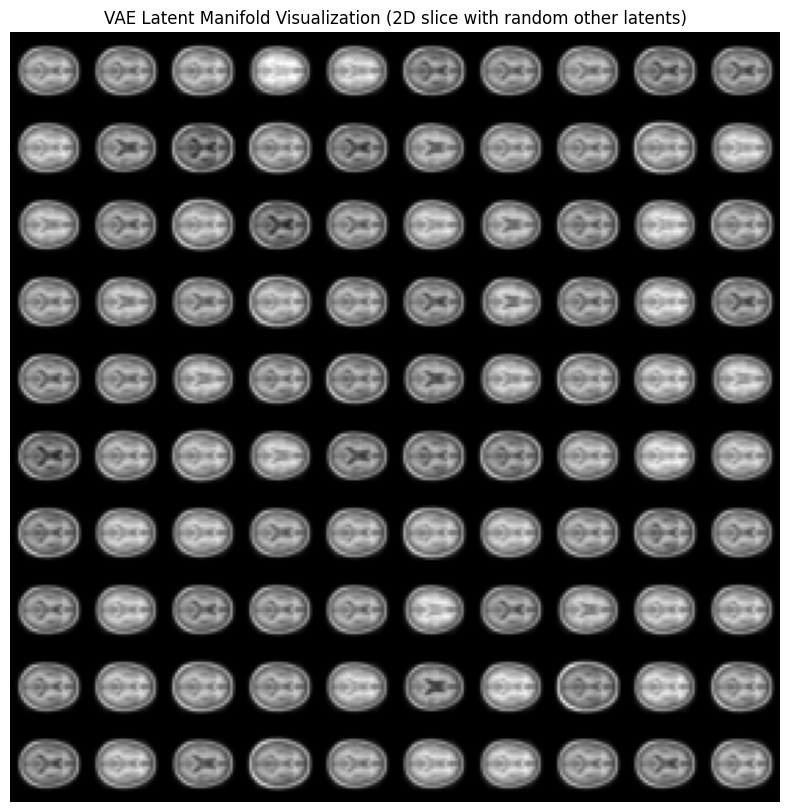

Generating latent space visualization using UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


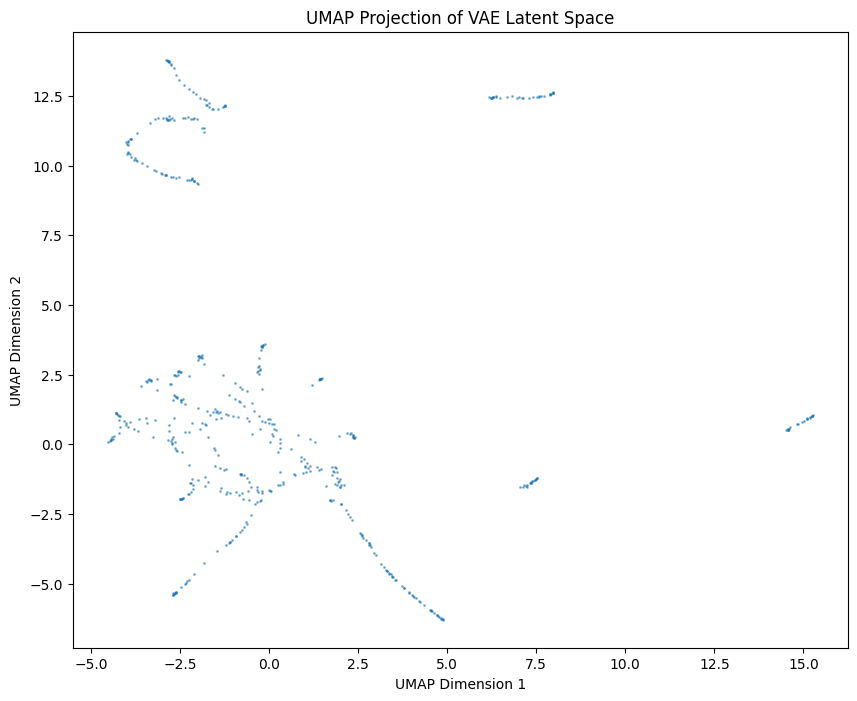

# 4.2 UNET

Using device: cuda
Train data path: /content/drive/OASIS/keras_png_slices_train
Validation data path: /content/drive/OASIS/keras_png_slices_validate
No PNG images found in /content/drive/OASIS/keras_png_slices_train. Please check the path.


NameError: name 'train_loader' is not defined

# 4.3 GAN